In [19]:
from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix as CM,precision_score as PS,recall_score as RS
import matplotlib.pyplot as plt

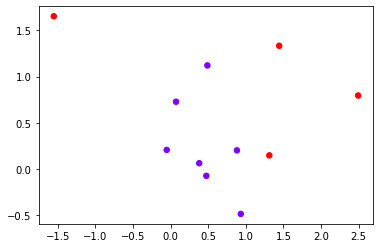

In [20]:
class_1=7
class_2=4
centers=[[0.0,0.0],[1,1]]
clusters_std=[0.5,1]
X,Y=make_blobs(n_samples=[class_1,class_2]
                 ,centers=centers
                 ,cluster_std=clusters_std
                 ,random_state=0
                 ,shuffle=False)
plt.scatter(X[:,0],X[:,1],cmap="rainbow",s=30,c=Y)

In [49]:
from sklearn.linear_model import LogisticRegression as LR
clf_lr=LR().fit(X,Y)
prob=clf_lr.predict_proba(X)
prob=pd.DataFrame(prob)
prob.columns=["0","1"]
prob

,0,1
0,0.694619,0.305381
1,0.510931,0.489069
2,0.820038,0.179962
3,0.785647,0.214353
4,0.777387,0.222613
5,0.656634,0.343366
6,0.768586,0.231414
7,0.349171,0.650829
8,0.366184,0.633816
9,0.663272,0.336728


In [50]:
for i in range(prob.shape[0]):
    if prob.iloc[i,1]>0.4:
        prob.loc[i,"pred"]=1
    else:
        prob.loc[i,"pred"]=0
prob["y_true"]=Y
prob=prob.sort_values(by="1",ascending=False)
prob

,0,1,pred,y_true
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
1,0.510931,0.489069,1.0,0
10,0.607529,0.392471,0.0,1
5,0.656634,0.343366,0.0,0
9,0.663272,0.336728,0.0,1
0,0.694619,0.305381,0.0,0
6,0.768586,0.231414,0.0,0
4,0.777387,0.222613,0.0,0
3,0.785647,0.214353,0.0,0


In [51]:
cm=CM(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])
cm

array([[2, 2],
       [1, 6]], dtype=int64)

In [52]:
#FPR
cm[1,0]/cm[1,:].sum()

0.14285714285714285

In [53]:
#recall
cm[0,0]/cm[0,:].sum()

0.5

SVM实现概率预测：重要参数probability，接口predict_proba以及decision_function
我们在画等高线，也就是决策边界的时候曾经使用SVC的接口decision_function，它返回我们输入的特征矩阵中每
个样本到划分数据集的超平面的距离。我们在SVM中利用超平面来判断我们的样本，本质上来说，当两个点的距离
是相同的符号的时候，越远离超平面的样本点归属于某个标签类的概率就很大。比如说，一个距离超平面0.1的
点，和一个距离超平面100的点，明显是距离为0.1的点更有可能是负类别的点混入了边界。同理，一个距离超平面
距离为-0.1的点，和一个离超平面距离为-100的点，明显是-100的点的标签更有可能是负类。所以，到超平面的距
离一定程度上反应了样本归属于某个标签类的可能性。接口decision_function返回的值也因此被我们认为是SVM
中的置信度（confidence）

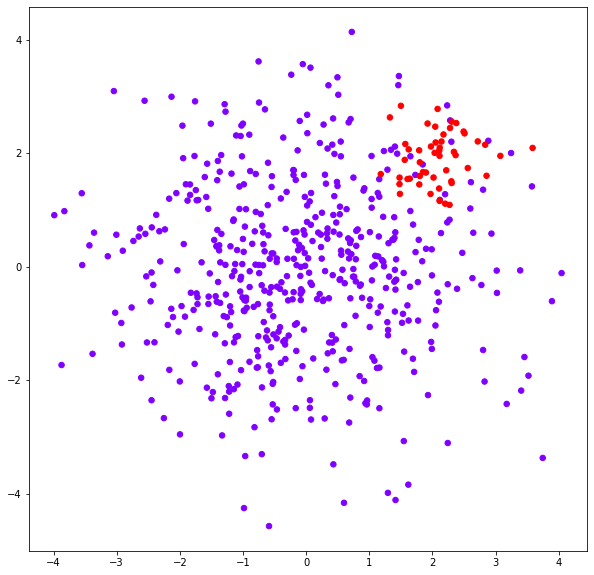

In [1]:
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
class_1=500
class_2=50
centers=[[0.0,0.0],[2.0,2.0]]
clusters_std=[1.5,0.5]
X,Y=make_blobs(n_samples=[class_1,class_2]
               ,centers=centers
               ,cluster_std=clusters_std
               ,random_state=0
               ,shuffle=False)
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1],c=Y,s=30,cmap="rainbow")
plt.show()

In [2]:
clf_svc=SVC(kernel="linear",probability=True).fit(X,Y)

In [6]:
#获得了SVM返回的概率
clf_svc.predict_proba(X).shape

(550, 2)

In [5]:
clf_svc.decision_function(X).shape

(550,)

值得注意的是，在二分类过程中，decision_function只会生成一列距离，样本的类别由距离的符号来判断，但是
predict_proba会生成两个类别分别对应的概率。SVM也可以生成概率，所以我们可以使用和逻辑回归同样的方式
来在SVM上设定和调节我们的阈值。
毋庸置疑，Platt缩放中涉及的交叉验证对于大型数据集来说非常昂贵，计算会非常缓慢。另外，由于Platt缩放的理
论原因，在二分类过程中，有可能出现predict_proba返回的概率小于0.5，但样本依旧被标记为正类的情况出现，
毕竟支持向量机本身并不依赖于概率来完成自己的分类。如果我们的确需要置信度分数，但不一定非要是概率形式
的话，那建议可以将probability设置为False，使用decision_function这个接口而不是predict_proba

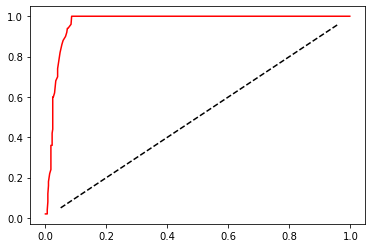

In [13]:
#在linspace方法中加了个endpoint表示取不到最后的一个值
from sklearn.metrics import confusion_matrix as CM,precision_score as PS,recall_score as RS
recall=[]
FPR=[]
probarange=np.linspace(clf_svc.predict_proba(X)[:,1].min()
                       ,clf_svc.predict_proba(X)[:,1].max(),num=50,endpoint=False)
for i in probarange:
    y_predict=[]
    for j in range(X.shape[0]):
        if clf_svc.predict_proba(X)[j,1]>i:
            y_predict.append(1)
        else:
            y_predict.append(0)
    cm=CM(Y,y_predict,labels=[1,0])
    recall.append(cm[0,0]/cm[0,:].sum())
    FPR.append(cm[1,0]/cm[1,:].sum())
recall.sort()
FPR.sort()
plt.plot(FPR,recall,color="red")
plt.plot(probarange+0.05,probarange+0.05,c="black",linestyle="--")
plt.show()

在sklearn中，我们有帮助我们计算ROC曲线的横坐标假正率FPR，纵坐标Recall和对应的阈值的类
sklearn.metrics.roc_curve。同时，我们还有帮助我们计算AUC面积的类sklearn.metrics.roc_auc_score。在一些比较老旧的sklearn版本中，我们使用sklearn.metrics.auc这个类来计算AUC面积，但这个类即将在0.22版本中被
放弃，因此建议大家都使用roc_auc_score。来看看我们的这两个类：

In [15]:
from sklearn.metrics import roc_curve,roc_auc_score
FPR,recall,thresholds=roc_curve(Y,clf_svc.decision_function(X),pos_label=1)

In [16]:
#假正率
FPR

array([0.   , 0.   , 0.006, 0.006, 0.008, 0.008, 0.01 , 0.01 , 0.014,
       0.014, 0.018, 0.018, 0.022, 0.022, 0.024, 0.024, 0.028, 0.028,
       0.03 , 0.03 , 0.032, 0.032, 0.036, 0.036, 0.04 , 0.04 , 0.042,
       0.042, 0.044, 0.044, 0.05 , 0.05 , 0.054, 0.054, 0.058, 0.058,
       0.066, 0.066, 0.072, 0.072, 0.074, 0.074, 0.086, 0.086, 1.   ])

In [17]:
#召回率
recall

array([0.  , 0.02, 0.02, 0.06, 0.06, 0.16, 0.16, 0.2 , 0.2 , 0.22, 0.22,
       0.36, 0.36, 0.42, 0.42, 0.6 , 0.6 , 0.62, 0.62, 0.64, 0.64, 0.68,
       0.68, 0.7 , 0.7 , 0.74, 0.74, 0.76, 0.76, 0.82, 0.82, 0.84, 0.84,
       0.86, 0.86, 0.88, 0.88, 0.92, 0.92, 0.94, 0.94, 0.96, 0.96, 1.  ,
       1.  ])

In [19]:
#阈值
thresholds

array([  3.18236076,   2.18236076,   1.48676267,   1.35964325,
         1.33920817,   1.14038015,   1.13383091,   1.00003406,
         0.85085628,   0.84476439,   0.78571364,   0.60568093,
         0.5389064 ,   0.46718521,   0.44396046,   0.03907036,
        -0.07011269,  -0.10668727,  -0.1258212 ,  -0.13845693,
        -0.14034183,  -0.16790648,  -0.2040958 ,  -0.22137683,
        -0.24381463,  -0.26762451,  -0.34446784,  -0.3467975 ,
        -0.39182241,  -0.40676459,  -0.4589064 ,  -0.46310299,
        -0.49195707,  -0.5088941 ,  -0.53560561,  -0.55152081,
        -0.62628865,  -0.67580418,  -0.78127198,  -0.79874442,
        -0.88438995,  -0.91257798,  -1.01417607,  -1.08601917,
       -10.31959605])

好了，现在我们有了这条曲线，我们的确知道模型的效果还算是不错了。但依然非常摸棱两可，有没有具体的数字
来帮助我们理解ROC曲线和模型的效果呢？的确存在，这个数字就叫做AUC面积，它代表了ROC曲线下方的面积，
这个面积越大，代表ROC曲线越接近左上角，模型就越好。AUC面积的计算比较繁琐，因此，我们使用sklearn来
帮助我们。接下来我们来看看，在sklearn当中，如何绘制我们的ROC曲线，找出我们的的AUC面积。

In [20]:
area=roc_auc_score(Y,clf_svc.decision_function(X))
area

0.9696400000000001

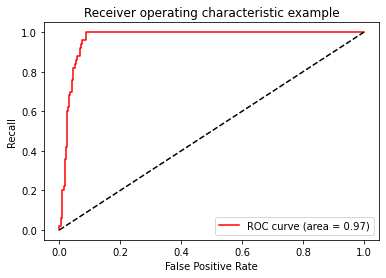

In [22]:
plt.figure()
plt.plot(FPR, recall, color='red',label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()